In [1]:
import keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from PIL import Image

In [2]:
#The first step is to load the data. The data is separated between the monet paintings that will be taken as real images for the discriminator
#The images are resized to 64x64 to ensure the model trains faster and would require less resources
monet_data = tf.keras.utils.image_dataset_from_directory("/kaggle/input/gan-getting-started/monet_jpg", seed=42, image_size=(64, 64), label_mode=None)

Found 300 files.


In [3]:
#Next the data is normalized. There are 300 Monet paintings and 7038 photos in the Kaggle dataset
monet_norm_data = monet_data.map(lambda x: x / 255.0)

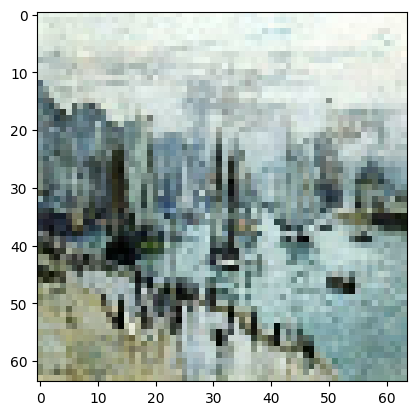

In [4]:
#Here I plot some of the Monet paintings to get a sense of what the goal for the GAN is
plt.imshow(list(monet_norm_data.as_numpy_iterator())[5][5])

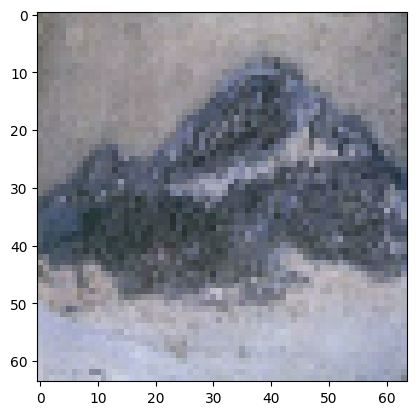

In [5]:
plt.imshow(list(monet_norm_data.as_numpy_iterator())[8][8])

In [6]:
monet_norm_data.element_spec

TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)

Each photo in the dataset is 64x64 and then is divided into 3 color channels. With the data normalized, the next step is to create the model.

In [7]:
#For the model I will utilize DCGANs with different parameters
#I started with the base model shown in the keras guide to serve as a control
base_generator = keras.Sequential([
    keras.layers.InputLayer(shape=(128,)),
    keras.layers.Dense(8*8*128),
    keras.layers.Reshape((8,8,128)),
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
], name="control_generator")



In [8]:
#The first change is to make the kernel smaller
kernel_generator = keras.Sequential([
    keras.layers.InputLayer(shape=(128,)),
    keras.layers.Dense(8*8*128),
    keras.layers.Reshape((8,8,128)),
    keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
], name="kernel_generator")
kernel_generator.summary()

Model: "kernel_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 128)    │        65,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 256)    │       131,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 512)    │       524,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,963 (6.93 MB)

 Trainable params: 1,816,963 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#The next modification is to make the slope of the leakyrelu steeper
relu_generator = keras.Sequential([
    keras.layers.InputLayer(shape=(128,)),
    keras.layers.Dense(8*8*128),
    keras.layers.Reshape((8,8,128)),
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.5),
    keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.5),
    keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.5),
    keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
], name="relu_generator")
relu_generator.summary()

Model: "relu_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#Similarly for the discriminator I started with the example as the control
base_discriminator = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid"),
], name="base_discriminator")
base_discriminator.summary()

Model: "base_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#The only change I tested with the discriminator is to increase the slope of the leaky relu function
slope_discriminator = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.5),
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.5),
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    keras.layers.LeakyReLU(negative_slope=0.5),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid"),
], name="slope_discriminator")
slope_discriminator.summary()

Model: "slope_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#The followimg code to assemble the GAN and override the training state can be found at https://keras.io/examples/generative/dcgan_overriding_train_step/#override-trainstep
class GAN(keras.Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, 128), seed=42
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, 128), seed=42
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [13]:
#In total as there are 2 discriminators and 3 generators, there are 6 possible GANs that can be formed
base_gan = GAN(base_discriminator, base_generator)
g_slope_gan = GAN(base_discriminator, relu_generator)
kernel_gan = GAN(base_discriminator, kernel_generator)
d_slope_gan = GAN(slope_discriminator, base_generator)
slope_gan = GAN(slope_discriminator, relu_generator)
leaky_kernel_gan = GAN(slope_discriminator, kernel_generator)


In [14]:
#As per the paper https://arxiv.org/pdf/1511.06434 the researchers found that the optimal learning rate is 0.0002
base_gan.compile(keras.optimizers.Adam(learning_rate=0.0002), keras.optimizers.Adam(learning_rate=0.0002), keras.losses.BinaryCrossentropy())
history = base_gan.fit(monet_norm_data, epochs=100)

Epoch 1/100


I0000 00:00:1734044058.743121      76 service.cc:145] XLA service 0x5711732bd230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734044058.743216      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734044058.743224      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734044058.975443      76 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
I0000 00:00:1734044074.068830      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - d_loss: 0.6753 - g_loss: 0.7463
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - d_loss: 0.5861 - g_loss: 0.8316
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - d_loss: 0.7592 - g_loss: 0.7485
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - d_loss: 0.6669 - g_loss: 0.9743
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - d_loss: 0.4992 - g_loss: 1.9243
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - d_loss: 0.4426 - g_loss: 1.9904
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - d_loss: 1.6636 - g_loss: 0.4194
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - d_loss: 0.7026 - g_loss: 1.1711
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - d_loss: 0.3806 - g_loss: 1.7067
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - d_loss: 0.1717 - g_loss: 3.0866
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - d_loss: 0.3152 - g_loss: 2.5814
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step -

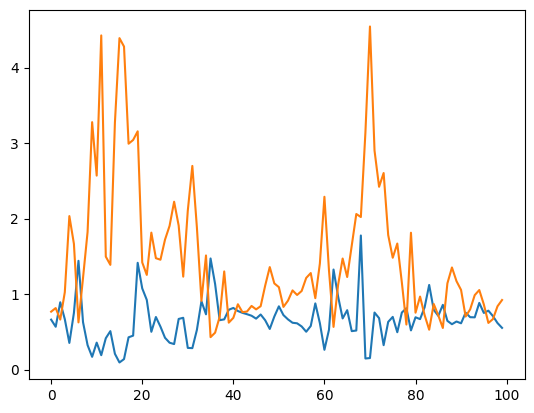

In [15]:
#Generally the loss of the discriminator stayed low as the generator took ~25 epochs to have a consistently low loss then it spikes a bit around 80 epochs
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])

In [16]:
#Overall each model will be trained over 50 epochs
g_slope_gan.compile(keras.optimizers.Adam(learning_rate=0.0002), keras.optimizers.Adam(learning_rate=0.0002), keras.losses.BinaryCrossentropy())
history = g_slope_gan.fit(monet_norm_data, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 612ms/step - d_loss: 0.6758 - g_loss: 0.8742
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - d_loss: 0.9870 - g_loss: 0.5720
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - d_loss: 0.7071 - g_loss: 0.6883
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - d_loss: 0.6858 - g_loss: 0.7054
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - d_loss: 0.5459 - g_loss: 1.1545
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - d_loss: 0.9116 - g_loss: 0.7806
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - d_loss: 1.1189 - g_loss: 0.6886
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - d_loss: 0.4788 - g_loss: 1.4992
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.4852 - g_loss: 1.6917
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.7253 - g_loss: 1.5655
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.3153 - g_loss: 2.3859
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 

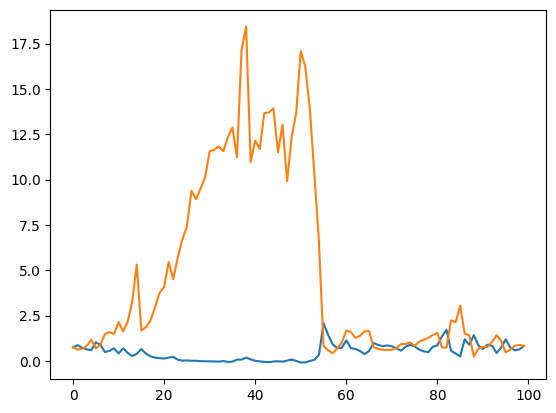

In [17]:
#Generally the loss of the generator diverges for the first 30 epochs but then converges and performs better than the baseline GAN
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])

In [18]:
kernel_gan.compile(keras.optimizers.Adam(learning_rate=0.0002), keras.optimizers.Adam(learning_rate=0.0002), keras.losses.BinaryCrossentropy())
history = kernel_gan.fit(monet_norm_data, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 654ms/step - d_loss: 0.5399 - g_loss: 0.9866
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - d_loss: 0.5617 - g_loss: 0.9762
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - d_loss: 0.4427 - g_loss: 1.9144
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 0.0848 - g_loss: 4.1043
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.4502 - g_loss: 1.8104
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 0.6759 - g_loss: 1.0475
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - d_loss: 0.7241 - g_loss: 1.0536
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 1.0628 - g_loss: 0.8037
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 0.7110 - g_loss: 1.4901
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 0.1397 - g_loss: 3.6384
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 0.2560 - g_loss: 3.7929
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 

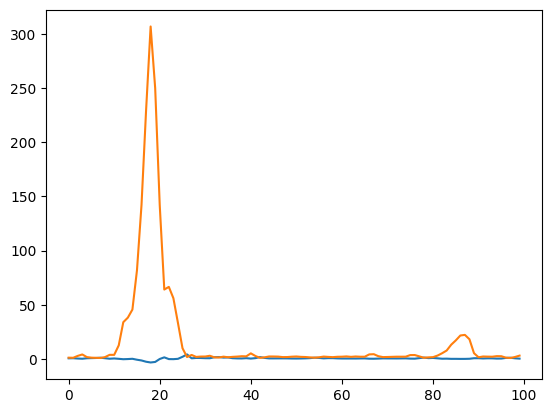

In [19]:
#Both models seemed to stay fairly low, it is unclear how well the generator learned
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])

In [20]:
d_slope_gan.compile(keras.optimizers.Adam(learning_rate=0.0002), keras.optimizers.Adam(learning_rate=0.0002), keras.losses.BinaryCrossentropy())
history = d_slope_gan.fit(monet_norm_data, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 609ms/step - d_loss: 0.6793 - g_loss: 0.7757
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - d_loss: 0.7305 - g_loss: 0.7070
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - d_loss: 0.5874 - g_loss: 1.1352
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - d_loss: 0.5990 - g_loss: 1.5688
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - d_loss: 0.8694 - g_loss: 1.5102
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - d_loss: 0.6472 - g_loss: 1.2612
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - d_loss: 0.3997 - g_loss: 1.9851
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.8980 - g_loss: 1.2032
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.4910 - g_loss: 2.8453
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.6095 - g_loss: 3.9138
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.8288 - g_loss: 3.6845
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 

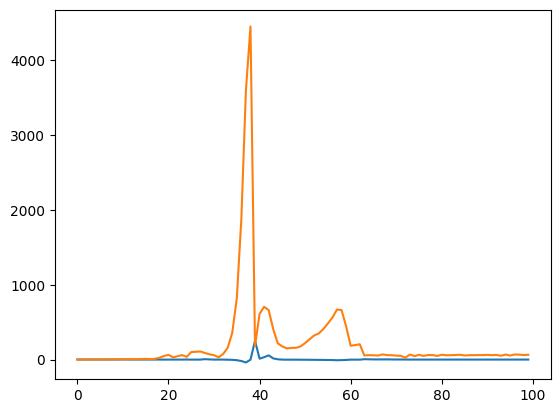

In [21]:
#From the plot the generator had trouble fooling the discriminator
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])

In [22]:
slope_gan.compile(keras.optimizers.Adam(learning_rate=0.0002), keras.optimizers.Adam(learning_rate=0.0002), keras.losses.BinaryCrossentropy())
history = slope_gan.fit(monet_norm_data, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 607ms/step - d_loss: 18.4819 - g_loss: 11.7477
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - d_loss: 32.7654 - g_loss: 1.6001
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - d_loss: 29.6374 - g_loss: 9.2006
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - d_loss: 29.1253 - g_loss: 0.2308
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - d_loss: 18.3710 - g_loss: 4.3159
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - d_loss: 14.1261 - g_loss: 0.0238
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - d_loss: 7.5005 - g_loss: 1.4455
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 5.9624 - g_loss: 0.2272
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - d_loss: 1.9643 - g_loss: 3.5278
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 0.8489 - g_loss: 2.5924
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - d_loss: 1.1210 - g_loss: 1.9120
Epoch 12/100
10/10 ━━━━━━━━━━━━━━

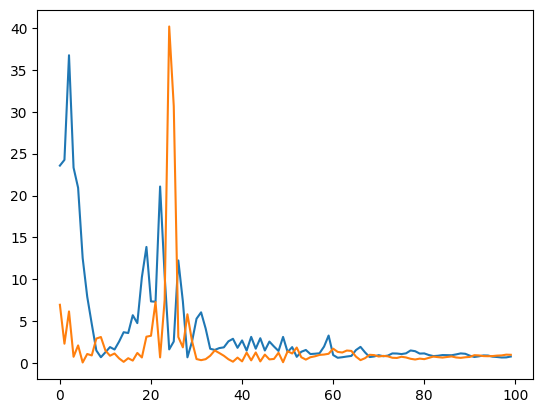

In [23]:
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])

In [24]:
leaky_kernel_gan.compile(keras.optimizers.Adam(learning_rate=0.0002), keras.optimizers.Adam(learning_rate=0.0002), keras.losses.BinaryCrossentropy())
history = leaky_kernel_gan.fit(monet_norm_data, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - d_loss: 0.6971 - g_loss: 2.1284
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - d_loss: 0.7838 - g_loss: 1.5163
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - d_loss: 1.8559 - g_loss: 0.6912
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - d_loss: 0.4105 - g_loss: 6.7021
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - d_loss: 3.1122 - g_loss: 1.1986
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - d_loss: 3.0084 - g_loss: 1.3001
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 1.6701 - g_loss: 1.7223
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 4.4997 - g_loss: 1.6411
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.2142 - g_loss: 8.9200
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - d_loss: 0.4112 - g_loss: 4.3391
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 2.3016 - g_loss: 1.2241
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2

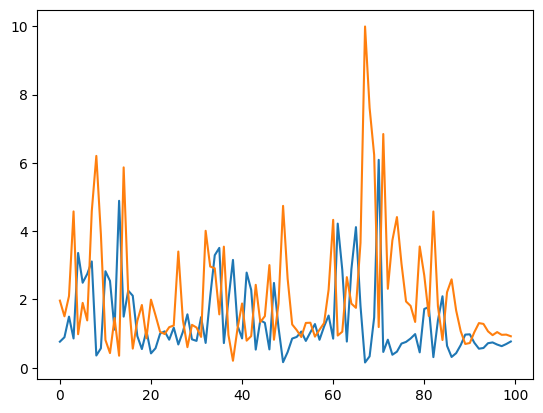

In [25]:
plt.plot(history.history["d_loss"])
plt.plot(history.history["g_loss"])

In [26]:
#To visualize how well each GAN predict on a random vector generated to represent vectors from the latent space
random_latent_vector = keras.random.normal(shape=(1, 128), seed=42)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


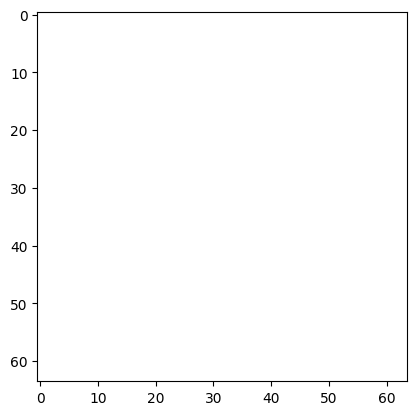

In [27]:
base_imgs = base_gan.generator.predict(random_latent_vector)
plt.imshow(base_imgs[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


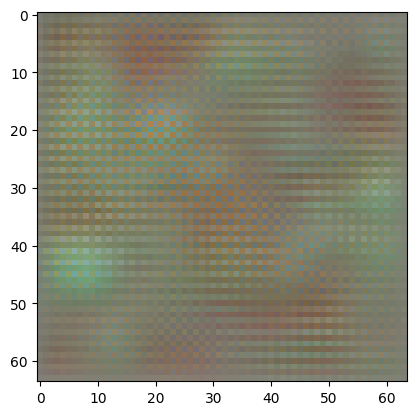

In [28]:
g_slope_imgs = g_slope_gan.generator.predict(random_latent_vector)
plt.imshow(g_slope_imgs[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


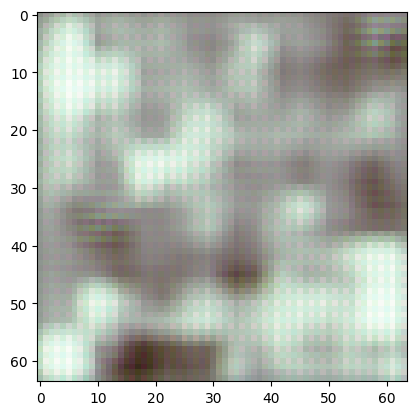

In [29]:
kernel_imgs = kernel_gan.generator.predict(random_latent_vector)
plt.imshow(kernel_imgs[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


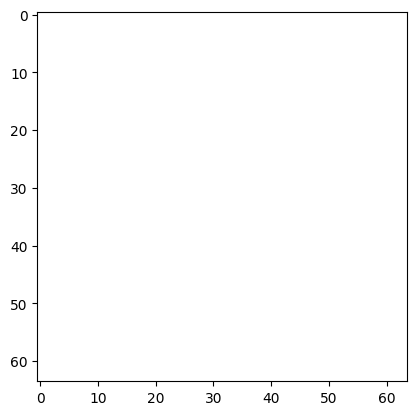

In [30]:
d_slope_img = d_slope_gan.generator.predict(random_latent_vector)
plt.imshow(d_slope_img[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


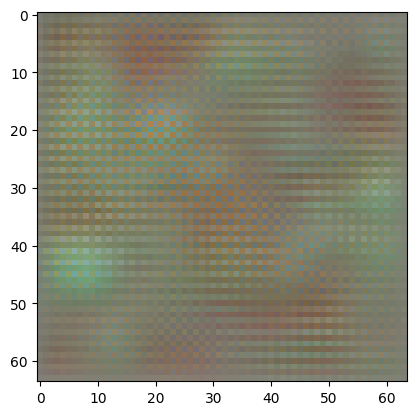

In [31]:
slope_img = slope_gan.generator.predict(random_latent_vector)
plt.imshow(slope_img[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


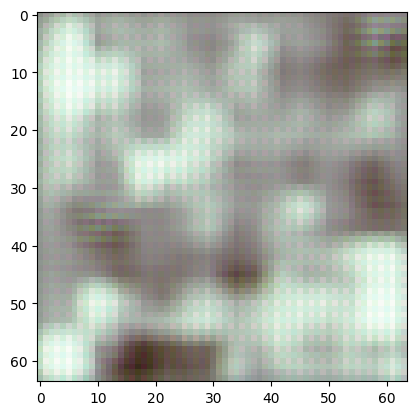

In [32]:
leaky_kernel_img = leaky_kernel_gan.generator.predict(random_latent_vector)
plt.imshow(leaky_kernel_img[0])

In [33]:
#Based on the above data the 'slope' GAN performed the best, additionally modifying the discriminator appeared to have little affect
final_GAN = slope_gan
submission_latent_vector = keras.random.normal(shape=(8000, 128), seed=42)
submission_imgs = final_GAN.generator.predict(submission_latent_vector)

250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step


In [34]:
submission_imgs*=255
submission_imgs.shape
submission_imgs[56]

array([[[124.687744, 123.98248 , 116.68611 ],
        [118.58484 , 121.36677 , 113.16285 ],
        [123.79187 , 120.047035, 109.92378 ],
        ...,
        [120.16582 , 118.89015 , 107.70593 ],
        [123.2345  , 121.96061 , 112.25939 ],
        [124.179924, 123.23376 , 115.13845 ]],

       [[121.76851 , 124.13046 , 116.63102 ],
        [126.231445, 123.36644 , 109.90792 ],
        [118.39541 , 120.13934 , 110.50357 ],
        ...,
        [123.78114 , 125.46442 , 108.10514 ],
        [121.07382 , 123.27589 , 114.91245 ],
        [126.46896 , 127.2208  , 115.0542  ]],

       [[124.8933  , 121.80994 , 113.40142 ],
        [117.86307 , 119.17774 , 110.03464 ],
        [125.78431 , 116.735825, 103.57859 ],
        ...,
        [119.05638 , 114.58514 , 103.493996],
        [123.46999 , 120.244995, 103.96208 ],
        [123.39698 , 121.92694 , 111.05804 ]],

       ...,

       [[126.08227 , 125.21896 , 115.75126 ],
        [130.00284 , 125.72862 , 105.25218 ],
        [126.08832 , 1

In [35]:
#Resize the image to 256x256 as per the Kaggle submission guidelines
kaggle_imgs = tf.image.resize(submission_imgs,[256,256])

In [36]:
import zipfile
from io import BytesIO
i = 0
with zipfile.ZipFile("/kaggle/working/images.zip", "w") as zip_file:
    for img in kaggle_imgs:
        jpg = Image.fromarray(img.numpy().astype(np.uint8))
        temp = BytesIO()
        jpg.save(temp, format="jpeg")
        temp.seek(0)
        zip_file.writestr(f"Generated_Image_{i}.jpg", temp.read())
        i+=1

In Conclusion, modifications to the discriminator had little effect on the results. For the generator, there was a performance boost when making the negative slope of the LeakyReLu larger and by making the filter size smaller in the generator. Generally, the GAN with the smallest generator loss was still was making a cloudy image. The next step, would be to look into longer training of the GANs as well as utilizing an encoder to convert the photos into the latent space instead of relying on random vectors.

References:
1. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks https://arxiv.org/abs/1511.06434.
2. DCGAN to generate face images https://keras.io/examples/generative/dcgan_overriding_train_step/#train-the-endtoend-model